## Load the Data and Understand it

In [1]:
#Questions
#do we have two adjacency matrices each for training and testing?

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)

In [4]:
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


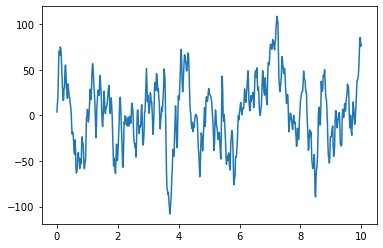

In [5]:
#print sample EGG signal from one node
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes()
X_train = variables["X_train"]
X_test = variables["X_test"]

ax.plot(np.linspace(0, 10, 640), X_train[:,5,0])

## Covariance Matrix Generation

In [6]:
#define some parameters
# D_0 is the feature dimension
# N is number of nodes
# M is the number of training example

D_0 = X_train.shape[0]
M_train = X_train.shape[2]
M_test = X_test.shape[2]
print(D_0, M_train, M_test)

640 1395 1518


In [7]:
#transpose X_train and X_test to M x N x D_0 
X_train = np.transpose(X_train, (2,1,0))
X_test = np.transpose(X_test, (2,1,0))
print(X_train.shape, X_test.shape)

(1395, 31, 640) (1518, 31, 640)


In [8]:
# X_bar is the average of each row (hence dimension M x N x 1)
X_bar_train = np.mean(X_train, axis = 2, keepdims = True)
X_bar_test = np.mean(X_test, axis = 2, keepdims = True)
print("X_bar:",X_bar_train.shape, X_bar_test.shape)
#X_norm = X - X_bar is every entry subtract the mean
X_norm_train = X_train - X_bar_train
X_norm_test = X_test - X_bar_test
print("X_norm:", X_norm_train.shape, X_norm_test.shape)

X_bar: (1395, 31, 1) (1518, 31, 1)
X_norm: (1395, 31, 640) (1518, 31, 640)


In [9]:
# buid P matrix (tensor since there are M examples) shape: MxNxN
P_train = 1/(D_0-1) * np.matmul((X_train - X_bar_train),np.transpose((X_train - X_bar_train), (0, 2, 1)))
P_test  = 1/(D_0-1) * np.matmul((X_test - X_bar_test),np.transpose((X_test - X_bar_test), (0, 2, 1)))
print("P", P_train.shape, P_test.shape)

P (1395, 31, 31) (1518, 31, 31)


In [10]:
#build Aggregated P_inv averaged along M . shape: NxN
#P_inv_train = np.linalg.inv(P_train)
#print(P_inv_train.shape)
sum_train = np.zeros(P_train.shape[1:])
remove_indices=[];
for i in range(P_train.shape[0]):
    #drop the samples that are non-invertable
    try: 
        sum_train+=np.linalg.inv(P_train[i,:,:])
        
    except:
        print("fail at sample", i)
        M_train -=1;
        
P_avg_train = 1/M_train * sum_train
print(P_avg_train, M_train)

sum_test = np.zeros(P_test.shape[1:])
for i in range(P_test.shape[0]):
    #drop the samples that are non-invertable
    try: 
        sum_test+=np.linalg.inv(P_test[i,:,:])
        
    except:
        print("fail at sample", i)
        M_test -=1;
        
P_avg_test = 1/M_test * sum_test
print(P_avg_test)

fail at sample 86
fail at sample 87
fail at sample 88
fail at sample 89
fail at sample 90
fail at sample 1015
fail at sample 1355
fail at sample 1356
[[ 1.55189334e-03  7.96737187e-04  6.24564737e-04 -6.41005813e-06
  -3.09113457e-05 -4.99016675e-05 -3.78575126e-05 -2.84472139e-05
  -2.00942820e-05 -2.23834184e-05  5.36959436e-07 -4.65566191e-05
  -1.77741240e-05 -1.53866366e-04 -5.78650590e-05 -1.12611827e-06
  -4.39187264e-04 -1.25981375e-05 -1.47829404e-05 -2.59585742e-05
  -1.01538784e-05  7.41081212e-06 -2.73085370e-05  1.75457401e-05
  -1.11682957e-04 -2.38627226e-04 -2.10575953e-04 -2.22118148e-04
  -2.23946738e-04 -1.46225076e-04 -1.24620207e-04]
 [ 7.96737187e-04  1.88761856e-03  1.18824240e-03 -4.11985236e-05
  -9.06499519e-05 -1.17650356e-04 -4.87097829e-05 -3.36094488e-05
  -3.72984931e-05 -3.26067573e-05 -1.74724164e-06 -1.10598683e-04
  -1.72985566e-04 -2.97657831e-04 -1.20433586e-04 -7.42333782e-05
  -6.85257922e-04 -1.51174867e-05 -2.53231246e-05 -2.65671534e-05
  -2.87

In [12]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    

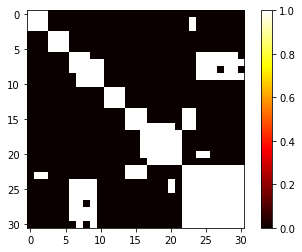

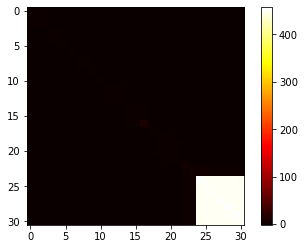

In [15]:
#threshold n
n = 10**(-4)
#compute A_train and A_test
A_train = (P_avg_train > n)
A_test = (P_avg_test > n)
show_heat_map(A_train)
show_heat_map(P_avg_train*10**3)

## Sanity Check

In [16]:
#create an averaged signal accross all X_train samples
X_train = variables["X_train"]
X_test = variables["X_test"]
X_train_avg = np.mean(X_train, axis = 2)
X_bar_train_avg = np.mean(X_bar_train, axis = 0)
X_train_avg = X_train_avg - np.transpose(X_bar_train_avg)
print(X_train_avg.shape, X_bar_train_avg.shape)

(640, 31) (31, 1)


In [17]:
#select highest covariance couples
h_couples = []
t_h = 4.514*10**-1
for i in range (P_avg_train.shape[0]):
    for j in range (P_avg_train.shape[0]):
        if i < j:
            if P_avg_train[i,j] > t_h:
                h_couples.append((i,j))
print(h_couples)

[(25, 27), (27, 28)]


<ipython-input-18-2bf6946ac17a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
<ipython-input-18-2bf6946ac17a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


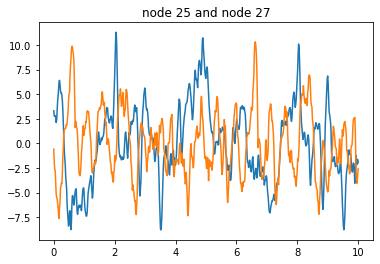

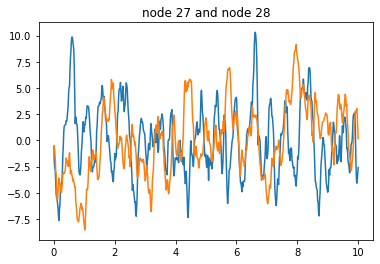

In [18]:
#graph the highest covariance couples
for couple in h_couples:
    plt.figure()
    plt.title('node ' + str(couple[0]) + " and node " + str(couple[1]))
    ax1 = plt.axes()
    ax1.plot(np.linspace(0, 10, 640), X_train_avg[:,couple[0]]);
    ax1.plot(np.linspace(0, 10, 640), X_train_avg[:,couple[1]]);

In [185]:
#select lowest covariance couples
l_couples = []
t_l = -10**-3#-9*10**-4
for i in range (P_avg_train.shape[0]):
    for j in range (P_avg_train.shape[0]):
        if i < j:
            if P_avg_train[i,j] < t_l:
                l_couples.append((i,j))
print(l_couples)

[(13, 16), (16, 30)]


<ipython-input-186-da0a20798966>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
<ipython-input-186-da0a20798966>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


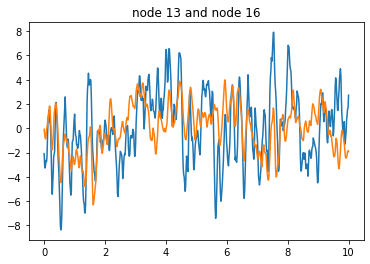

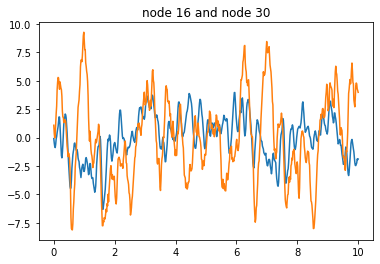

In [186]:
#graph the lowest covariance couples
for couple in l_couples:
    plt.figure()
    plt.title('node ' + str(couple[0]) + " and node " + str(couple[1]))
    ax1 = plt.axes()
    ax1.plot(np.linspace(0, 10, 640), X_train_avg[:,couple[0]]);
    ax1.plot(np.linspace(0, 10, 640), X_train_avg[:,couple[1]]);

<ipython-input-168-e3f161c29e20>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
<ipython-input-168-e3f161c29e20>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
<ipython-input-168-e3f161c29e20>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

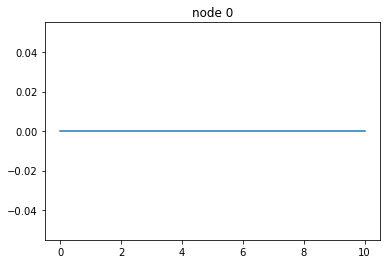

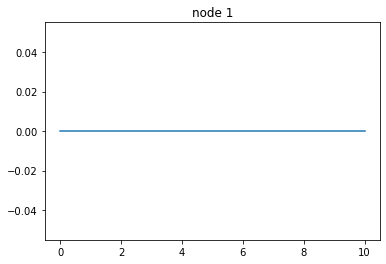

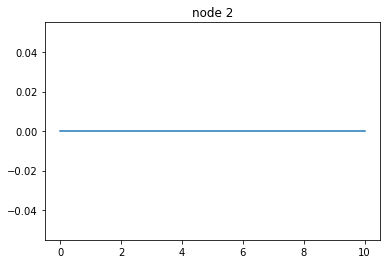

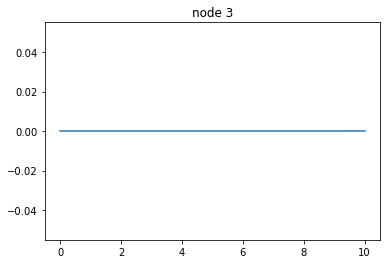

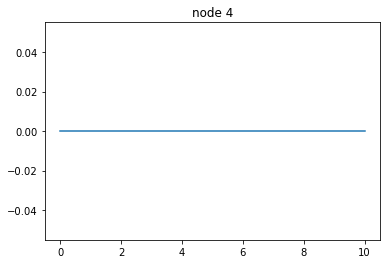

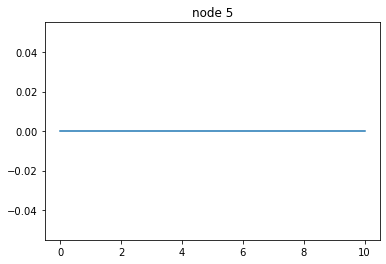

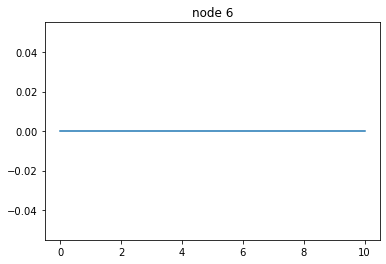

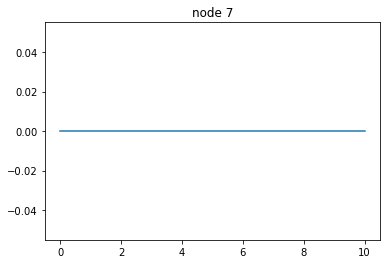

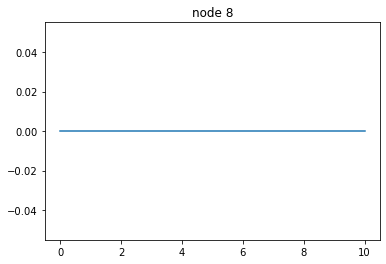

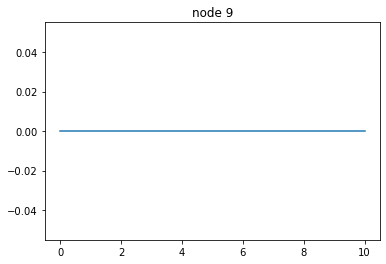

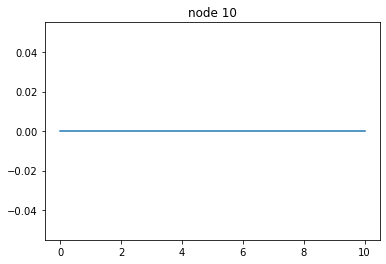

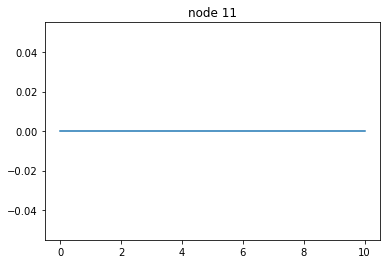

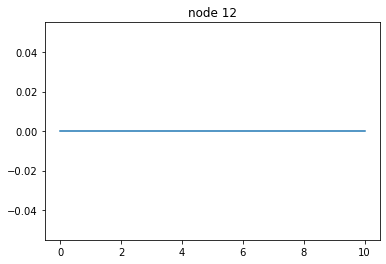

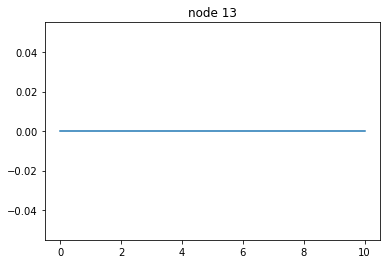

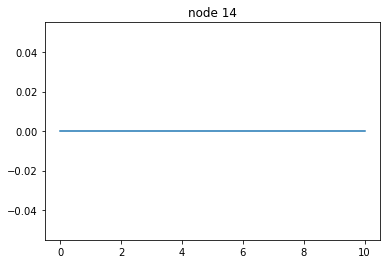

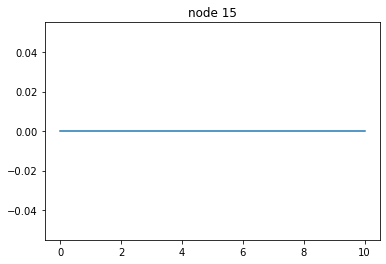

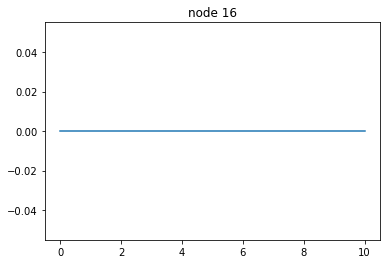

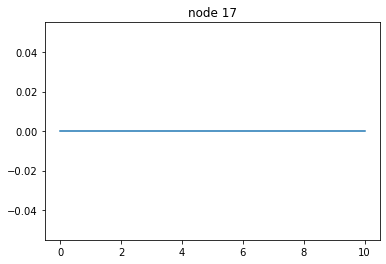

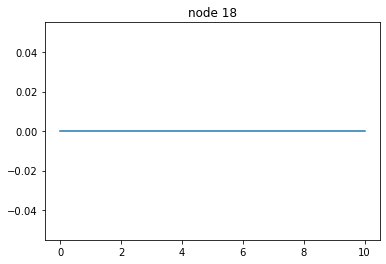

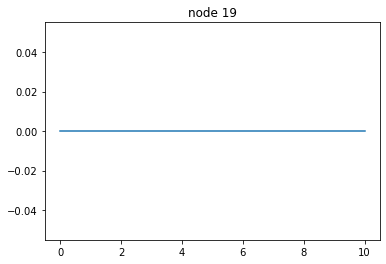

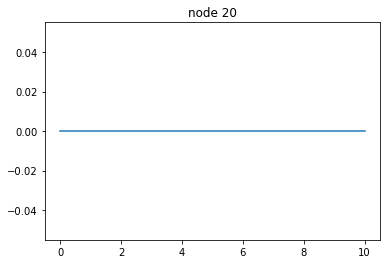

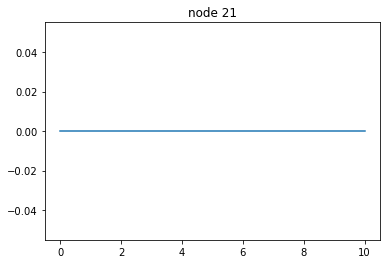

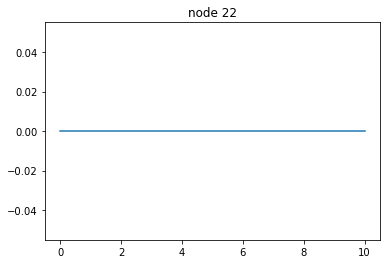

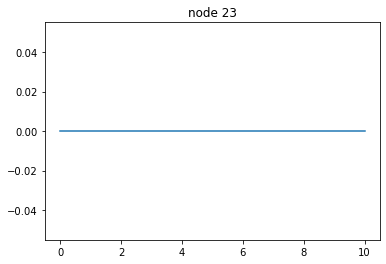

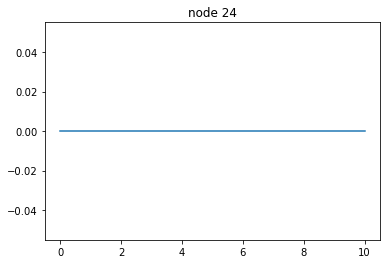

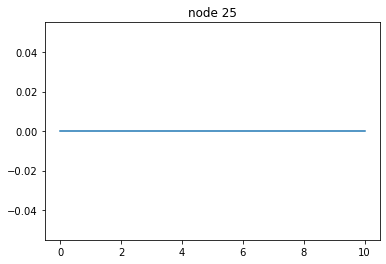

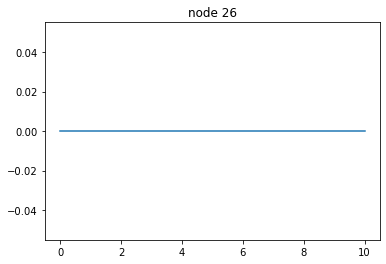

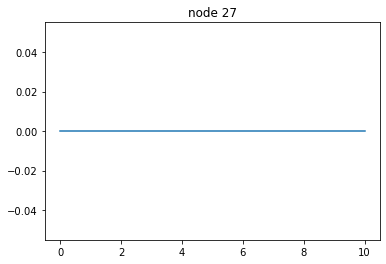

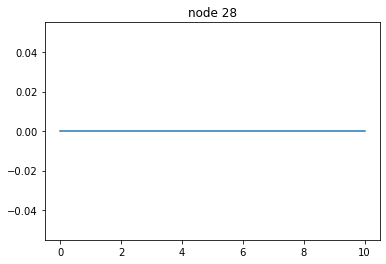

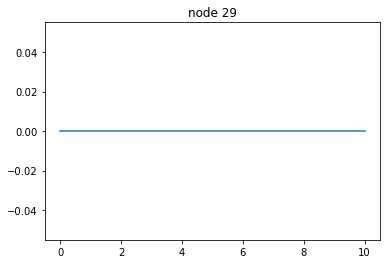

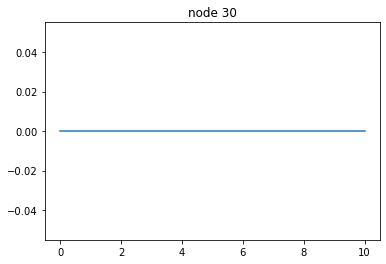

In [168]:
#check the non-invertible ones
sample = 88
for i in range(0, 31):
    plt.figure()
    plt.title('node ' + str(i))
    ax1 = plt.axes()
    ax1.plot(np.linspace(0, 10, 640), X_train[:,i,sample]);